In [1]:
import glob
import pickle
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Dense
from keras.models import Model
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
import matplotlib.pyplot as plt
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers.merge import Add
from keras.models import load_model

Using TensorFlow backend.


In [2]:
base_folder = 'E:\\Python Workspace\\Obstacle Avoidance\\'

In [3]:
records = glob.glob(base_folder+'Records\\*.xlsx')
fakes = glob.glob(base_folder+'Fakes\\*.xlsx')

In [4]:
record_data = []
for f in records:
    table = pd.read_excel(f)
    if len(record_data) > 0:
        record_data = np.concatenate((record_data,table.values),axis=0)
    else:
        record_data = table.values.copy()
print(record_data.shape)

(22707, 182)


In [5]:
mirror_record_data = np.concatenate((-record_data[:,0:1],record_data[:,1:][:,::-1]),axis=1)
print(mirror_record_data.shape)

(22707, 182)


In [6]:
fake_data = []
for f in fakes:
    table = pd.read_excel(f)
    if len(fake_data) > 0:
        fake_data = np.concatenate((fake_data,table.values),axis=0)
    else:
        fake_data = table.values.copy()
print(fake_data.shape)

(21999, 182)


In [6]:
data = np.concatenate((record_data,mirror_record_data),axis=0)
print(data.shape)

(45414, 182)


In [7]:
data = np.concatenate((record_data,mirror_record_data,fake_data),axis=0)
print(data.shape)

(67413, 182)


In [32]:
data_file = open(base_folder+'data.p','wb')
pickle.dump(np.array(data),data_file)
data_file.close()

In [4]:
data_file = open(base_folder+'data.p','rb')
data = pickle.load(data_file)
data_file.close()

In [5]:
X_data = np.array(data[:,1:])
y_data = np.array(data[:,0])
print(X_data.shape)
print(y_data.shape)

(67413, 181)
(67413,)


Preprocessing

In [6]:
X_data_mod = X_data.copy()
X_data_mod[X_data_mod>2000]=2000
Y_data_mod = y_data.copy()
print(X_data_mod.shape)
print(Y_data_mod.shape)

(67413, 181)
(67413,)


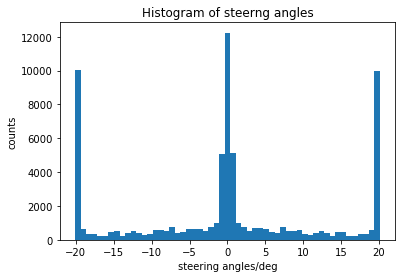

In [10]:
# Plot the histogram of labels
plt.hist(Y_data_mod*57.5, bins='auto')  # plt.hist passes it's arguments to np.histogram
plt.title("Histogram of steerng angles")
plt.xlabel("steering angles/deg")
plt.ylabel("counts")
plt.savefig('label hist 2',dpi=1000)
plt.show()


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_data_mod, Y_data_mod, test_size=0.05)

In [8]:
def show_env_action(detection,action):
    theta = np.linspace(0,np.pi,181)
    radii = detection.copy()
    width = np.pi / 180
    
    theta = np.concatenate((theta,[action+np.pi/2]))
    radii = np.concatenate((radii,[2000]))/1000
    
    ax = plt.subplot(111, projection='polar')
    ax.set_rticks([0.5, 1.0, 1.5, 2.0])  # less radial ticks
    ax.set_rlabel_position(-90)  # get radial labels away from plotted line
    bars = ax.bar(theta, radii, width=width, bottom=0.0)
    
    bars[-1].set_facecolor((1,0,0,1))
    
    
    #plt.figure(figsize=(10,10),dpi=200)
    plt.savefig('sample',dpi=600)
    plt.show()

In [9]:
def show_multi_env_action(X,y,nrows,ncols,name):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, subplot_kw=dict(polar=True))
    for ax in axes.flatten():
        index = np.random.randint(len(y))
        detection = X[index]
        action = y[index]

        theta = np.linspace(0,np.pi,181)
        radii = detection.copy()
        width = np.pi / 180

        theta = np.concatenate((theta,[action+np.pi/2]))
        radii = np.concatenate((radii,[2000]))/1000

        ax.set_rticks([0.5, 1.0, 1.5, 2.0])  # less radial ticks
        ax.set_rlabel_position(-90)  # get radial labels away from plotted line
        bars = ax.bar(theta, radii, width=width, bottom=0.0)
        bars[-1].set_facecolor((1,0,0,1))

    plt.savefig(name,dpi=600)
    plt.show()

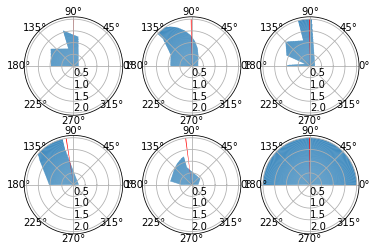

In [43]:
show_multi_env_action(X_train,y_train,2,3,'multi_samples')

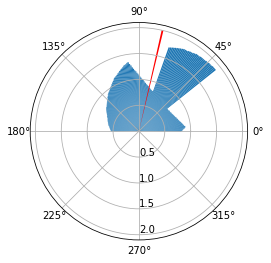

In [41]:
index = np.random.randint(0,20000)
show_env_action(X_train[index],y_train[index])

In [10]:
model = Sequential([
    Conv1D(filters=32,kernel_size=(9,),activation='relu',input_shape=(181,1),strides=2),
    Conv1D(filters=16,kernel_size=(7,),activation='relu',input_shape=(181,1),strides=2),
    Conv1D(filters=8,kernel_size=(5,),activation='relu',input_shape=(181,1),strides=2),
    Flatten(),
    Dense(16,activation='relu'),
    Dense(16,activation='relu'),
    Dense(16,activation='relu'),
    Dense(16,activation='relu'),
    Dense(16,activation='relu'),
    Dense(1)
])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 87, 32)            320       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 41, 16)            3600      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 19, 8)             648       
_________________________________________________________________
flatten_1 (Flatten)          (None, 152)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2448      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
__________

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
training_history = model.fit(np.expand_dims(X_train, axis=2), y_train, batch_size=1024, epochs=300, validation_split=0.05)

Train on 60839 samples, validate on 3203 samples
Epoch 1/300
60839/60839 [==============================] - 2s - loss: 0.8441 - val_loss: 0.0752
Epoch 2/300
60839/60839 [==============================] - 0s - loss: 0.0633 - val_loss: 0.0557
Epoch 3/300
60839/60839 [==============================] - 0s - loss: 0.0504 - val_loss: 0.0462
Epoch 4/300
60839/60839 [==============================] - 0s - loss: 0.0423 - val_loss: 0.0403
Epoch 5/300
60839/60839 [==============================] - 0s - loss: 0.0376 - val_loss: 0.0370
Epoch 6/300
60839/60839 [==============================] - 0s - loss: 0.0350 - val_loss: 0.0352
Epoch 7/300
60839/60839 [==============================] - 0s - loss: 0.0333 - val_loss: 0.0336
Epoch 8/300
60839/60839 [==============================] - 0s - loss: 0.0321 - val_loss: 0.0324
Epoch 9/300
60839/60839 [==============================] - 0s - loss: 0.0309 - val_loss: 0.0315
Epoch 10/300
60839/60839 [==============================] - 0s - loss: 0.0299 - val_los

60839/60839 [==============================] - 0s - loss: 0.0133 - val_loss: 0.0154
Epoch 86/300
60839/60839 [==============================] - 0s - loss: 0.0133 - val_loss: 0.0137
Epoch 87/300
60839/60839 [==============================] - 0s - loss: 0.0131 - val_loss: 0.0144
Epoch 88/300
60839/60839 [==============================] - 0s - loss: 0.0132 - val_loss: 0.0136
Epoch 89/300
60839/60839 [==============================] - 0s - loss: 0.0130 - val_loss: 0.0139
Epoch 90/300
60839/60839 [==============================] - 0s - loss: 0.0131 - val_loss: 0.0141
Epoch 91/300
60839/60839 [==============================] - 0s - loss: 0.0131 - val_loss: 0.0135
Epoch 92/300
60839/60839 [==============================] - 0s - loss: 0.0130 - val_loss: 0.0145
Epoch 93/300
60839/60839 [==============================] - 0s - loss: 0.0129 - val_loss: 0.0134
Epoch 94/300
60839/60839 [==============================] - 0s - loss: 0.0129 - val_loss: 0.0135
Epoch 95/300
60839/60839 [=================

60839/60839 [==============================] - 0s - loss: 0.0111 - val_loss: 0.0112
Epoch 169/300
60839/60839 [==============================] - 0s - loss: 0.0109 - val_loss: 0.0110
Epoch 170/300
60839/60839 [==============================] - 0s - loss: 0.0107 - val_loss: 0.0109
Epoch 171/300
60839/60839 [==============================] - 0s - loss: 0.0110 - val_loss: 0.0111
Epoch 172/300
60839/60839 [==============================] - 0s - loss: 0.0107 - val_loss: 0.0110
Epoch 173/300
60839/60839 [==============================] - 0s - loss: 0.0107 - val_loss: 0.0107
Epoch 174/300
60839/60839 [==============================] - 0s - loss: 0.0107 - val_loss: 0.0111
Epoch 175/300
60839/60839 [==============================] - 0s - loss: 0.0105 - val_loss: 0.0109
Epoch 176/300
60839/60839 [==============================] - 0s - loss: 0.0105 - val_loss: 0.0109
Epoch 177/300
60839/60839 [==============================] - 0s - loss: 0.0105 - val_loss: 0.0110
Epoch 178/300
60839/60839 [=======

60839/60839 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0103
Epoch 252/300
60839/60839 [==============================] - 0s - loss: 0.0093 - val_loss: 0.0103
Epoch 253/300
60839/60839 [==============================] - 0s - loss: 0.0091 - val_loss: 0.0107
Epoch 254/300
60839/60839 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0100
Epoch 255/300
60839/60839 [==============================] - 0s - loss: 0.0091 - val_loss: 0.0098
Epoch 256/300
60839/60839 [==============================] - 0s - loss: 0.0091 - val_loss: 0.0101
Epoch 257/300
60839/60839 [==============================] - 0s - loss: 0.0089 - val_loss: 0.0106
Epoch 258/300
60839/60839 [==============================] - 0s - loss: 0.0093 - val_loss: 0.0102
Epoch 259/300
60839/60839 [==============================] - 0s - loss: 0.0091 - val_loss: 0.0099
Epoch 260/300
60839/60839 [==============================] - 0s - loss: 0.0091 - val_loss: 0.0101
Epoch 261/300
60839/60839 [=======

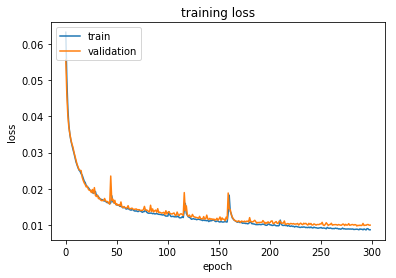

In [14]:
# Plot the history of training
fig = plt.figure() #figsize=(8,6)
plt.plot(training_history.history['loss'][1:])
plt.plot(training_history.history['val_loss'][1:])
plt.title('training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')
plt.savefig('record_data_training_2.png',dpi=600)
plt.show()

In [15]:
np.sqrt(0.0099)*57.5

5.7211777633630652

In [16]:
pred_test = model.predict(np.expand_dims(X_test, axis=2))

In [17]:
model.evaluate(np.expand_dims(X_test, axis=2), y_test)

2752/3371 [=======================>......] - ETA: 0s

0.010161751689230766

In [18]:
def show_multi_env_action(X,y_pred,y_truth,nrows,ncols,name):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, subplot_kw=dict(polar=True))
    for ax in axes.flatten():
        index = np.random.randint(len(y_pred))
        detection = X[index]
        pred_action = y_pred[index]
        truth_action = y_truth[index]
        
        theta = np.linspace(0,np.pi,181)
        radii = detection.copy()
        width = np.pi / 180

        theta = np.concatenate((theta,[pred_action+np.pi/2,truth_action+np.pi/2]))
        radii = np.concatenate((radii,[2000,2000]))/1000

        ax.set_rticks([0.5, 1.0, 1.5, 2.0])  # less radial ticks
        ax.set_rlabel_position(-90)  # get radial labels away from plotted line
        bars = ax.bar(theta, radii, width=width, bottom=0.0)
        bars[-2].set_facecolor((1,0,0,1))
        bars[-1].set_facecolor((0,1,0,1))

    plt.savefig(name,dpi=600)
    plt.show()

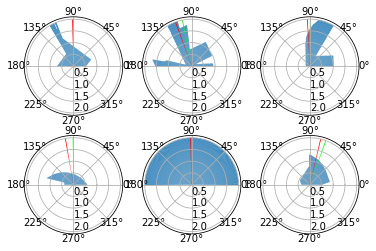

In [19]:
show_multi_env_action(X_test,pred_test,y_test,2,3,'test_samples_2')

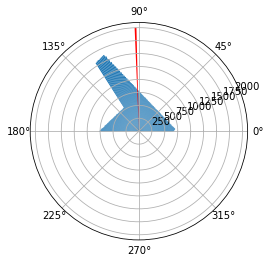

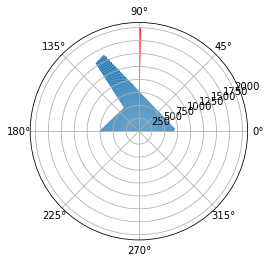

In [83]:
index = np.random.randint(0,500)

show_env_action(X_test[index],pred_test[index][0])
show_env_action(X_test[index],y_test[index])

In [84]:
model.save('Best.h')